In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
from flopy.utils import Raster
from flopy.utils.gridgen import Gridgen
from flopy.utils.gridintersect import GridIntersect
from shapely.geometry import Point, LineString
import shapefile

print(f'Flopy version: {flopy.__version__}')

Flopy version: 3.3.5


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 1 Workspace setup  
Completely separate from the rest of the repo

In [3]:
#Define model names and workspaces
ml_name = 'experimental' # Model name
ml_ws = os.path.join('..', ml_name) # Flopy model workspace
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries
temp_gridgen_ws = os.path.join('..', 'experimental_model')
raster_pth = os.path.join('..', 'data', 'raw_data', 'rasters')
shapefile_pth = os.path.join('..', 'data', 'raw_data', 'shapefiles')

Load shapefiles:

In [4]:
ml_boundary = shapefile.Reader(os.path.join(shapefile_pth, 'ml_boundary.shp')) # Model boundary shapefile
mlb_shape = np.array(np.rint(ml_boundary.shapeRecords()[0].shape.points)) # Model boundary array
orbacken = shapefile.Reader(os.path.join(shapefile_pth, 'orbacken_sfr.shp')) # Creek Örbäcken shapefile
orbacken_shp = np.concatenate([np.rint(i.shape.points) for i in orbacken.shapeRecords()]) # Creek Örbäcken array

## 2 Model grid setup
### 2.1 The base model grid
Starting with a 45 degree rotated square base-model with a grid-size of 10 x 10 meters:

In [5]:
# SWEREF99TM Coordinates & meters above sea level
xmin, xmax, ymin, ymax, zmin, zmax = 426900, 427700, 6654650, 6655350, 115, 159
ncol, nrow, nlay = int((xmax - xmin) / 10), int((ymax - ymin) / 10), 3
delc, delr = 10, 10
xoff, yoff, rotation = 427200, 6654450, 45

print(f'Number of cells in the base-grid: {str(ncol * nrow * nlay)}')

Number of cells in the base-grid: 16800


Instantiate the base-model:

In [6]:
ml = flopy.modflow.Modflow()

dis = flopy.modflow.ModflowDis(model = ml, nlay = nlay, nrow = nrow, ncol = ncol,
                               delr = delr, delc = delc, top = zmax, botm = [145, 130, zmin],
                               proj4_str = 'ESPG:3006', xul = xmin, yul = ymax)

ml.modelgrid.set_coord_info(xoff=xoff, yoff=yoff, angrot=rotation, epsg = 3006)

Plot the base-model:

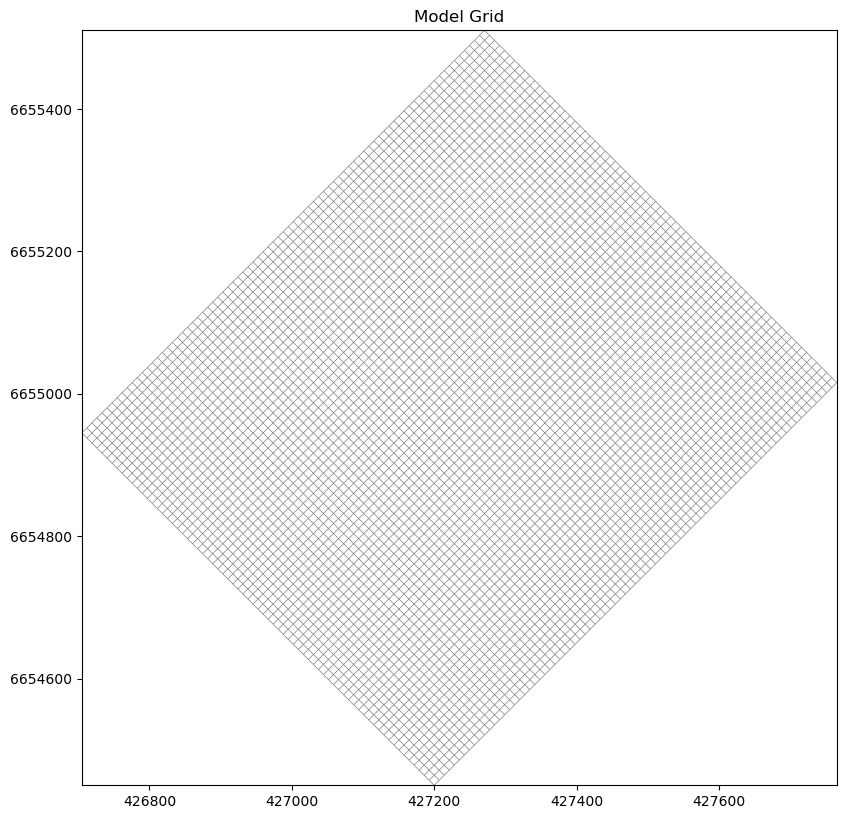

In [7]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
mapview = flopy.plot.PlotMapView(model=ml)
linecollection = mapview.plot_grid(lw=0.5)

t = ax.set_title("Model Grid")

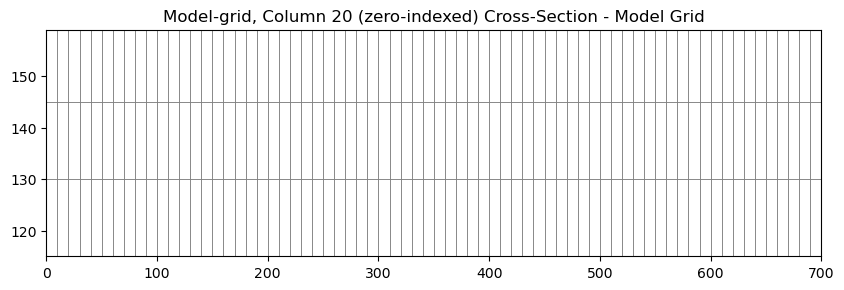

In [8]:
fig = plt.figure(figsize=(10, 3), dpi=100)
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=ml, line={'Column': 20})
plt.ticklabel_format(axis='both', style='plain', useOffset=False)

linecollection = xsect.plot_grid(linewidth=0.5)
t = ax.set_title('Model-grid, Column 20 (zero-indexed) Cross-Section - Model Grid')

### 2.2 Adding topography
Define path to rasters and shapefiles:

In [9]:
raster_pth = os.path.join('..', 'data', 'raw_data', 'rasters')
shapefile_pth = os.path.join('..', 'data', 'raw_data', 'shapefiles')

Load rasters:

In [10]:
lyr1_top = Raster.load(os.path.join(raster_pth, 'lyr1_top.txt'))
lyr1_botm = Raster.load(os.path.join(raster_pth, 'lyr1_botm.txt'))
lyr2_botm = Raster.load(os.path.join(raster_pth, 'lyr2_botm.txt'))
lyr3_botm = Raster.load(os.path.join(raster_pth, 'lyr3_botm.txt'))

Load shapefiles:

In [11]:
ml_boundary = shapefile.Reader(os.path.join(shapefile_pth, 'ml_boundary.shp')) # Model boundary shapefile
mlb_shape = np.array(np.rint(ml_boundary.shapeRecords()[0].shape.points)) # Model boundary array

In [12]:
orbacken = shapefile.Reader(os.path.join(shapefile_pth, 'orbacken_sfr.shp')) # Creek Örbäcken shapefile
orbacken_shp = np.concatenate([np.rint(i.shape.points) for i in orbacken.shapeRecords()]) # Creek Örbäcken array

Plot GIS-data:

In [13]:
min_elevations = []
max_elevations = []
for raster in [lyr1_top, lyr1_botm, lyr2_botm, lyr3_botm]:
    data = raster.sample_polygon(mlb_shape, band=raster.bands[0])
    min_elevations.append(np.min(data))
    max_elevations.append(np.max(data))

vmin, vmax = np.min(min_elevations), np.max(max_elevations)

Top elevation: 158.43 m.a.s.l., bottom elevation: 115.46 m.a.s.l.


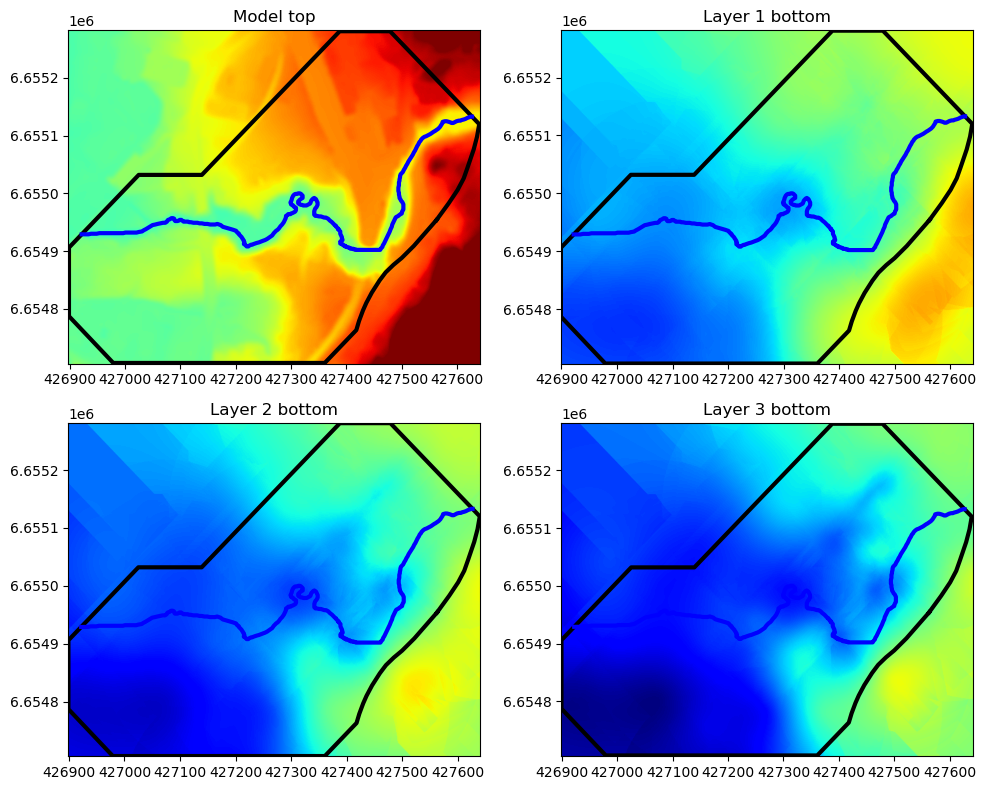

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(10,8), dpi=100)
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot rasters
lyr1_top.plot(ax=axs[0, 0], vmin=vmin, vmax=vmax, cmap='jet', aspect='auto')
lyr1_botm.plot(ax=axs[0, 1], vmin=vmin, vmax=vmax, cmap='jet', aspect='auto')
lyr2_botm.plot(ax=axs[1, 0], vmin=vmin, vmax=vmax, cmap='jet', aspect='auto')
lyr3_botm.plot(ax=axs[1, 1], vmin=vmin, vmax=vmax, cmap='jet', aspect='auto')

# Display model boundary
for ax in axs.flat:
    ax.plot(mlb_shape[:,0],mlb_shape[:,1], c='k', lw=3, label='Model boundary')
    ax.plot(orbacken_shp[:,0],orbacken_shp[:,1], c='blue', lw=3, label='Örbäcken')

# Set subplot titles
axs[0, 0].set_title('Model top')
axs[0, 1].set_title('Layer 1 bottom')
axs[1, 0].set_title('Layer 2 bottom')
axs[1, 1].set_title('Layer 3 bottom')

print(f'Top elevation: {vmax:.2f} m.a.s.l., bottom elevation: {vmin:.2f} m.a.s.l.')
plt.tight_layout()

Define function for applying topography to the base-model grid:

In [15]:
def resample_raster(rasterfile):
    return rasterfile.resample_to_grid(
            ml.modelgrid,
            band=rasterfile.bands[0],
            method="nearest"
        )

Resample raster data:

In [16]:
lyr1_top_grid = resample_raster(lyr1_top)
lyr1_botm_grid = resample_raster(lyr1_botm)
lyr2_botm_grid = resample_raster(lyr2_botm)
lyr3_botm_grid = resample_raster(lyr3_botm)

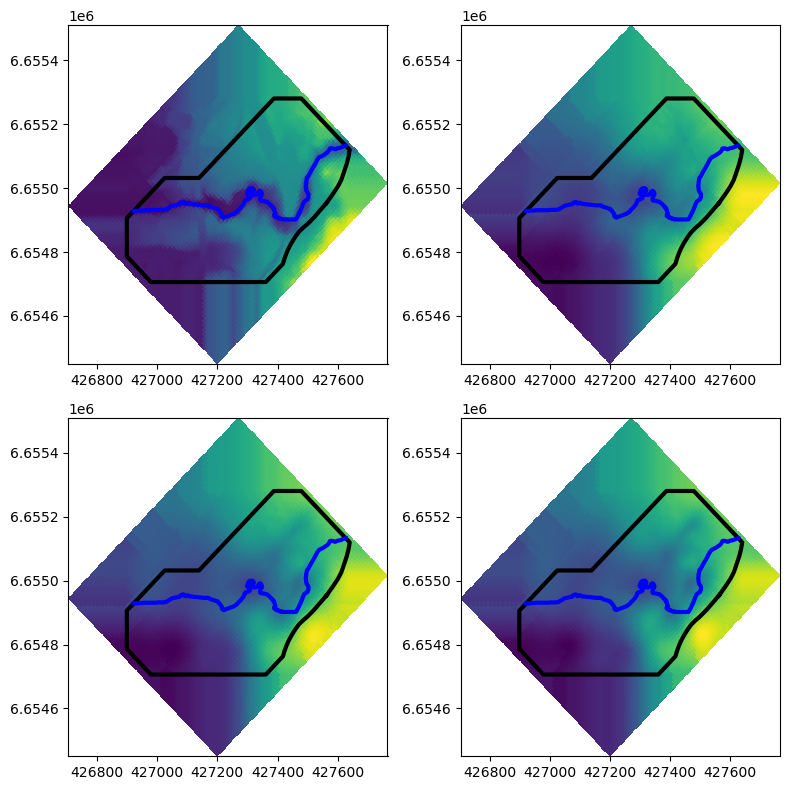

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(8,8), dpi=100)

# Display model boundary
for ax in axs.flat:
    ax.plot(mlb_shape[:,0],mlb_shape[:,1], c='k', lw=3, label='Model boundary')
    ax.plot(orbacken_shp[:,0],orbacken_shp[:,1], c='blue', lw=3, label='Örbäcken')

pmv1 = flopy.plot.PlotMapView(modelgrid=ml.modelgrid, ax=axs[0, 0])
ax1 = pmv1.plot_array(lyr1_top_grid)

pmv2 = flopy.plot.PlotMapView(modelgrid=ml.modelgrid, ax=axs[0, 1])
ax2 = pmv2.plot_array(lyr1_botm_grid)

pmv3 = flopy.plot.PlotMapView(modelgrid=ml.modelgrid, ax=axs[1, 0])
ax3 = pmv3.plot_array(lyr2_botm_grid)

pmv4 = flopy.plot.PlotMapView(modelgrid=ml.modelgrid, ax=axs[1, 1])
ax4 = pmv4.plot_array(lyr3_botm_grid)

plt.tight_layout()

Assign the resampled grids as model layer elevations:

In [18]:
ml.dis.top = lyr1_top_grid
ml.dis.botm = [lyr1_botm_grid, lyr2_botm_grid, lyr3_botm_grid]

Plot cross section to verify model-grid resampling:

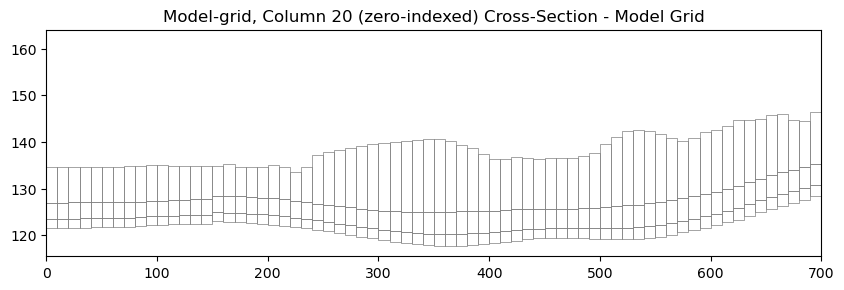

In [19]:
fig = plt.figure(figsize=(10, 3), dpi=100)
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=ml, line={'Column': 20})
plt.ticklabel_format(axis='both', style='plain', useOffset=False)

linecollection = xsect.plot_grid(linewidth=0.5)
t = ax.set_title('Model-grid, Column 20 (zero-indexed) Cross-Section - Model Grid')

## 2.3 Build unstructed grid using GRIDGEN

Instantiate a gridgen object to convert the structured grid (DIS) into a refined unstructured grid (DISV):

In [20]:
g = Gridgen(
    ml.dis,
    model_ws=temp_gridgen_ws,
    exe_name=os.path.join(bins_pth, 'gridgen.exe')
)

Add active domain in order to inactivate cells outside of model boundary:

In [21]:
g.add_active_domain([[np.rint(ml_boundary.shapeRecords()[0].shape.points)]], range(nlay))

Refine model grid (refinement level 1 - this could be refined further when a suitable workflow is determined) along creek Örbäcken:

In [22]:
g.add_refinement_features([[orbacken_shp]], 'line', 1, range(nlay))

Build model grid:

In [23]:
g.build(verbose=False)

In [24]:
print(f'Number of cells in grid: {g.get_nodes()}')

Number of cells in grid: 9405


Plot model grid (for some reason the model grid is not extending out into the model boundary at locations where creek Örbäcken enters and leaves the model domain):

Text(0.5, 1.0, 'Gridgen result')

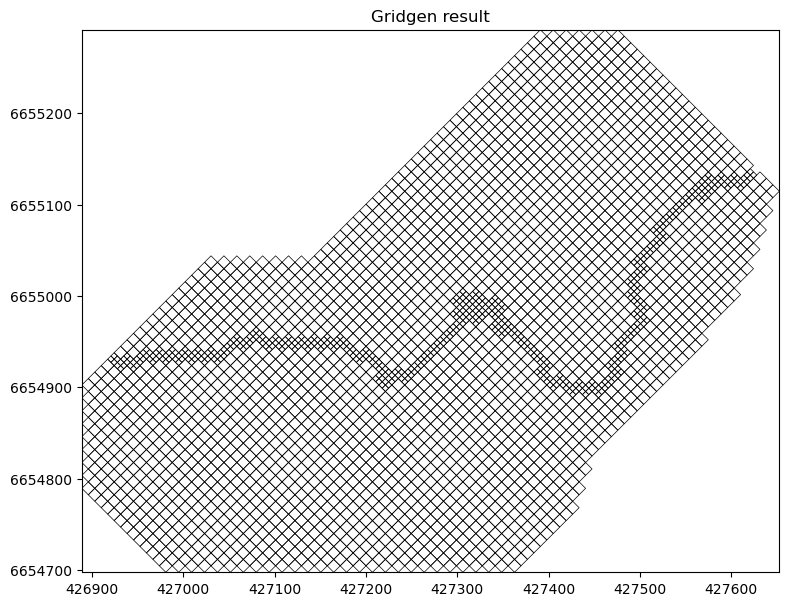

In [25]:
fig = plt.figure(figsize=(9, 9), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
g.plot(ax, linewidth=0.5)
plt.title('Gridgen result')

## 2.4 Instantiate a MF6 unstructured grid (DISV)
Extract the Grid Properties:

In [26]:
gridprops = g.get_gridprops_disv()

In [27]:
ncpl = gridprops['ncpl']
top = gridprops['top']
botm = gridprops['botm']
nvert = gridprops['nvert']
vertices = gridprops['vertices']
cell2d = gridprops['cell2d']

Cleanup temporary gridgen directory:

In [28]:
if os.path.exists(temp_gridgen_ws):
    shutil.rmtree(temp_gridgen_ws)

Setup MODFLOW simulation package:

In [29]:
sim = flopy.mf6.MFSimulation(
    sim_name = ml_name,
    version = 'mf6',
    exe_name = os.path.join(bins_pth, 'mf6'), 
    sim_ws = ml_ws
)

Setup temporal discretization package:

In [30]:
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim,
    pname = 'tdis',
    time_units = 'DAYS',
    #start_date_time = '2016-01-01',
    nper = 2,
    perioddata = [(1.0, 1, 1.0), (1460, 4*12, 1.0)]
)

Setup groundwater flow package:

In [31]:
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=ml_name,
    model_nam_file='{}.nam'.format(ml_name),
    newtonoptions ='under_relaxation'
)

gwf.name_file.save_flows = True

Setup iterative model solution package:

In [32]:
ims = flopy.mf6.ModflowIms( # The following settings allow SFR to converge (default settings won't)
    sim,                    # Settings could possibly be tuned to allow faster convergence though.
    pname='ims',
    print_option='SUMMARY',
    complexity='SIMPLE',
    outer_dvclose = 1e-2,
    outer_maximum = 750,
    inner_maximum = 50,
    linear_acceleration = 'bicgstab'  
)
sim.register_ims_package(ims, [ml_name])

Setup the model grid package with properties extracted from GRIDGEN earlier:

In [33]:
disv = flopy.mf6.ModflowGwfdisv(
    gwf,
    nlay=nlay,
    ncpl=ncpl, 
    top=top,
    botm=botm,
    nvert=nvert,
    vertices=vertices,
    cell2d=cell2d,
    length_units='METERS',
    filename='{}.disv'.format(ml_name)
)

In [34]:
gwf.modelgrid.set_coord_info(proj4='ESPG:3006')
gwf.modelgrid

xll:0.0; yll:0.0; rotation:0.0; proj4_str:ESPG:3006; units:meters; lenuni:2

Setup initial conditions package:

In [35]:
ic = flopy.mf6.ModflowGwfic(
    gwf, pname='ic',
    strt=138.0,
    filename='{}.ic'.format(ml_name)
)

Setup node property flow package:

In [36]:
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    pname='npf',
    save_flows=True,
    icelltype=[1,0,0],
    k=[86.4, 86.4, 43.2],
    k33=[8.64, 8.64, 0.1]
)

Setup output control package:

In [37]:
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    pname='oc',
    budget_filerecord='{}.cbb'.format(ml_name),
    head_filerecord='{}.hds'.format(ml_name),
    headprintrecord=[('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 6, 'GENERAL')],
    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
    printrecord=[('HEAD', 'FIRST'), ('HEAD', 'LAST'), ('BUDGET', 'LAST')]
)

Setup storage package:

In [38]:
sy = flopy.mf6.ModflowGwfsto.sy.empty(gwf, layered=True)

for layer in range(0,3):
    sy[layer]['data'] = 0.2
    
ss = flopy.mf6.ModflowGwfsto.ss.empty(
    gwf,
    layered=True,
    default_value=0.000001
)

sto = flopy.mf6.ModflowGwfsto(
    gwf, pname='sto',
    save_flows=True,
    iconvert=1, 
    ss=ss, sy=sy,
    steady_state={0:True},
    transient={1:True}
)

# 3 Setup boundary conditions
Linear BCs will be setup using the GridIntersect tool, which enable interaction with the model grid in a GIS-like manner:

In [39]:
ix = GridIntersect(gwf.modelgrid)

## 3.1 General head boundary condition (GHB)

In order to avoid using an excessive amount of shapefiles, lines used for intersecting the model grid are created using numpy and shapely:

In [40]:
line1 = np.array([(427474, 6655285), (427650, 6655110)])
line2 = np.array([(427405, 6655288), (427464, 6655288)])
line3 = np.array([(427142, 6655038), (427393, 6655288)])
line4 = np.array([(427046, 6655042), (427128, 6655042)])
line5 = np.array([(426890, 6654898), (427030, 6655038)])
line6 = np.array([(426892, 6654808), (426892, 6654884)])
line7 = np.array([(426990, 6654695), (426890, 6654795)])
line8 = np.array([(427340, 6654700), (427005, 6654700)])
line9 = np.array([(427430, 6654770), (427355, 6654698)])
line10 = np.array([(427445, 6654810), (427435, 6654785)])
line11 = np.array([(427570, 6654950), (427445, 6654825)])
line12 = np.array([(427605, 6655000), (427570, 6654965)])
line13 = np.array([(427620, 6655030), (427605, 6655015)])
line14 = np.array([(427642, 6655095), (427630, 6655050)])

ghb_locations = [line1, line2, line3, line4, line5, line6, line7,
                 line8, line9, line10, line11, line12, line13, line14]
line_colors = ['red', 'orangered', 'orange', 'gold', 'yellowgreen', 'limegreen', 'aqua', 'darkturquoise',
               'royalblue', 'blue', 'blueviolet', 'purple', 'mediumvioletred', 'crimson']

Plot the lines ontop of the model grid. These will be used to intersect the grid and apply GHB boundary condition (boundnames will be the same as the color to facilitate cell identification in post processing):

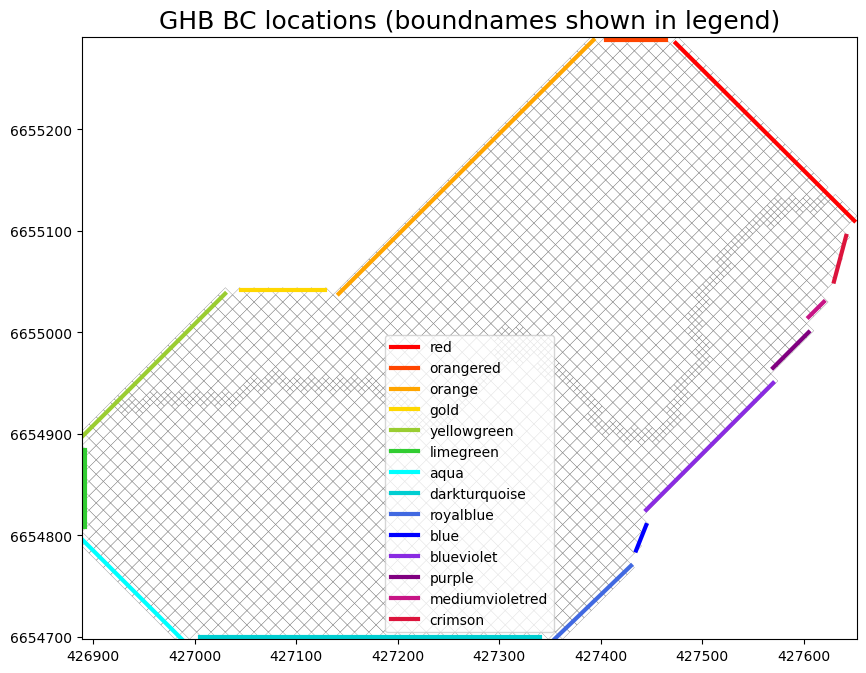

In [41]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('GHB BC locations (boundnames shown in legend)', fontsize=18)

# use PlotMapView to plot a DISV (vertex) model
mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

for line, color in zip(ghb_locations, line_colors):
    plt.plot(line.T[0], line.T[1], color=color, lw=3, label=color)
    
plt.legend()
plt.show()

Construct a dictionary containing data that will be used for the GHB package during the initial run (pre-PEST):

In [42]:
ghb_cells = {
    'cell_id': [],
    'bhead': [],
    'cond': [],
    'boundname': [],
}

Intersect the model grid using the lines shown above and append corresponding cell id and boundname:

In [43]:
for line, color in zip(ghb_locations, line_colors):
    GHB_intersect = LineString(line)
    GHB_cells = ix.intersect(GHB_intersect)

    ghb_cells['cell_id'].append(GHB_cells.cellids)
    
    for cell in range(len(GHB_cells)):
        ghb_cells['boundname'].append(color)

Concatenate arrays of cell ids into a single array and prepend layer number to cell ids:

In [44]:
ghb_cells['cell_id'] = np.concatenate(ghb_cells['cell_id']).ravel() # Concatenate arrays of cell ids
ghb_cells['cell_id'] = [(0, i) for i in ghb_cells['cell_id']] # Prepend layer number (Zero indexed)

Append hydraulic conductivity initial guess (86.4 m/day) to all GHB BCs:

In [45]:
ghb_cells['cond'] = [86.4 for i in range(len(ghb_cells['cell_id']))]

Define a dictionary that contain boundary head initial guess for each boundname (to be adjusted by PEST during history matching):

In [46]:
initial_ghb_bheads = {
    'red': 142.5,
    'orangered': 143.0,
    'orange': 137.5,
    'gold': 135.5,
    'yellowgreen': 134.5,
    'limegreen': 133.6,
    'aqua': 133.2,
    'darkturquoise': 133.2,
    'royalblue': 134.,
    'blue': 134.5,
    'blueviolet': 137.,
    'purple': 138.,
    'mediumvioletred': 139.,
    'crimson': 140.,
}

Append initial boundary head to corresponding cells:

In [47]:
for cell, bname in zip(ghb_cells['cell_id'], ghb_cells['boundname']):
    for color, bhead in initial_ghb_bheads.items():
        if bname == color:
            ghb_cells['bhead'].append(bhead)

Display the data that will be used to construct the GHB package:

In [48]:
ghb_df = pd.DataFrame(ghb_cells)
display(ghb_df)

,cell_id,bhead,cond,boundname
0,"(0, 829)",142.5,86.4,red
1,"(0, 912)",142.5,86.4,red
2,"(0, 995)",142.5,86.4,red
3,"(0, 1075)",142.5,86.4,red
4,"(0, 1155)",142.5,86.4,red
...,...,...,...,...
175,"(0, 3015)",139.0,86.4,mediumvioletred
176,"(0, 3016)",139.0,86.4,mediumvioletred
177,"(0, 2854)",140.0,86.4,crimson
178,"(0, 2919)",140.0,86.4,crimson


In [49]:
disv.botm.array[0][3134]

142.14219665527344

Ensure that bheads are >= cell bottom:

In [50]:
bhead_updated = [] # Should have a better name
for cid, head in zip(ghb_df['cell_id'], ghb_df['bhead']):
    if head < disv.botm.data[0][cid[1]]:
        bhead_updated.append(disv.botm.data[0][cid[1]])
    else:
        bhead_updated.append(head)

In [51]:
ghb_df['bhead'] = bhead_updated

In [52]:
display(ghb_df)

,cell_id,bhead,cond,boundname
0,"(0, 829)",142.500000,86.4,red
1,"(0, 912)",142.500000,86.4,red
2,"(0, 995)",142.500000,86.4,red
3,"(0, 1075)",142.500000,86.4,red
4,"(0, 1155)",142.500000,86.4,red
...,...,...,...,...
175,"(0, 3015)",143.648804,86.4,mediumvioletred
176,"(0, 3016)",143.819107,86.4,mediumvioletred
177,"(0, 2854)",140.385696,86.4,crimson
178,"(0, 2919)",141.427597,86.4,crimson


Construct the GHB package:

In [53]:
ghb_spd = []

In [54]:
for index, row in ghb_df.iterrows():
    ghb_spd.append([row['cell_id'], row['bhead'], row['cond'], row['boundname']])

In [55]:
ghb_spd = {0: ghb_spd}

In [56]:
ghb = flopy.mf6.modflow.mfgwfghb.ModflowGwfghb(
    gwf,
    print_input=True,
    print_flows=True,
    save_flows=True,
    boundnames=True, 
    pname='ghb',
    stress_period_data=ghb_spd
)

## Recharge

In [57]:
recharge_initial_guess = 200 / 1000 / 365 # 200 mm year ~~ 0.00054 m/day

In [58]:
non_ghb_cells = [i[1] for i in ghb_df['cell_id']]

In [60]:
rchcells = np.array(list(range(gridprops['ncpl'])), dtype=int)
rchcells[non_ghb_cells] = -1
rch_spd = [
    (0, rchcells[i], recharge_initial_guess) for i in range(ncpl) if rchcells[i] > 0
]
rch_spd = {0: rch_spd, 1: rch_spd}

In [61]:
rch_spd

{0: [(0, 6, 0.0005479452054794521),
  (0, 7, 0.0005479452054794521),
  (0, 23, 0.0005479452054794521),
  (0, 24, 0.0005479452054794521),
  (0, 25, 0.0005479452054794521),
  (0, 26, 0.0005479452054794521),
  (0, 27, 0.0005479452054794521),
  (0, 28, 0.0005479452054794521),
  (0, 29, 0.0005479452054794521),
  (0, 30, 0.0005479452054794521),
  (0, 31, 0.0005479452054794521),
  (0, 32, 0.0005479452054794521),
  (0, 33, 0.0005479452054794521),
  (0, 34, 0.0005479452054794521),
  (0, 35, 0.0005479452054794521),
  (0, 36, 0.0005479452054794521),
  (0, 37, 0.0005479452054794521),
  (0, 38, 0.0005479452054794521),
  (0, 39, 0.0005479452054794521),
  (0, 40, 0.0005479452054794521),
  (0, 41, 0.0005479452054794521),
  (0, 42, 0.0005479452054794521),
  (0, 43, 0.0005479452054794521),
  (0, 44, 0.0005479452054794521),
  (0, 45, 0.0005479452054794521),
  (0, 46, 0.0005479452054794521),
  (0, 47, 0.0005479452054794521),
  (0, 48, 0.0005479452054794521),
  (0, 49, 0.0005479452054794521),
  (0, 52, 0.0

In [62]:
rch = flopy.mf6.ModflowGwfrch(
    gwf,
    filename='{}.rch'.format(ml_name),
    stress_period_data=rch_spd,
    pname='rch',
    #auxiliary='MULTIPLIER',
    #auxmultname='MULTIPLIER',
    #boundnames=True,
    print_input=True,
    print_flows=True, 
    save_flows=True,
    fixed_cell=True,
)

## Evapotranspiration (TBD)

## 3.3 Streamflow routing boundary condition (SFR)

The SFR package is an advanced MODFLOW package that needs five types of data. These are `DIMENSION`, `PACKAGEDATA`, `CONNECTIONDATA`, `DIVERSIONS` and `PERIOD` data. `DIMENSION` is simply the number of reaches that are defined in the SFR package. Details of the `PACKAGEDATA` are specified below (this is the labor intensive part of SFR):

- rno = Reach number, a unique number for each cell
- cellid = Model cell ID, a unique number, for the corresponding reach number
- rlen = real value that defines the reach length. RLEN must be greater than zero.
- rwid = real value that defines the reach width. RWID must be greater than zero.
- rgrd: real value that defines the stream gradient (slope) across the reach. RGRD must be greater than zero.
- rtp: real value that defines the top elevation of the reach streambed.
- rbth: real value that defines the thickness of the reach streambed.
- rhk: real value that defines the hydraulic conductivity of the reach streambed.
- man: real or character value that defines the Manning’s roughness coefficient for the reach.
- ncon: integer value that defines the number of reaches connected to the reach.
- ustrf: real value that defines the fraction of upstream flow from each upstream reach that is applied as upstream inflow to the reach.
- ndv: integer value that defines the number of downstream diversions for the reach.
- boundname: name of the stream reach cell.

`CONNECTIONDATA` specifies which reaches are connected with eachother. This is fairly simple to script.

`DIVERSIONS` can be omitted, because we treat Creek Örbäcken as a single stream of water.

`PERIOD` Stress period info.

### 3.3.1 Intersect and sample grid data
We will be using a shapefile to intersect the model grid:

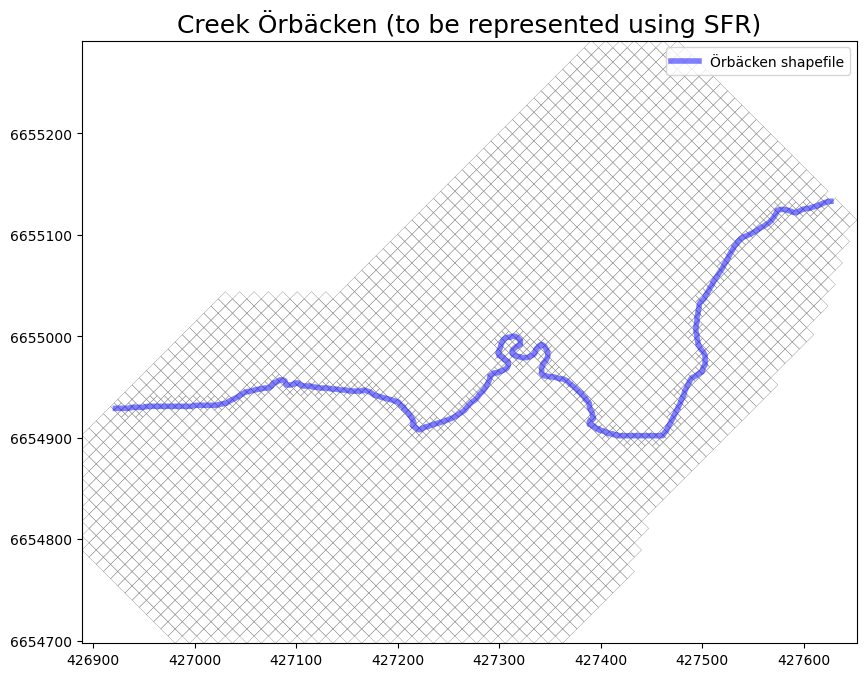

In [63]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Creek Örbäcken (to be represented using SFR)', fontsize=18)

# use PlotMapView to plot a DISV (vertex) model
mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

# Display model boundary
ax.plot(orbacken_shp[:,0],orbacken_shp[:,1], c='blue', lw=4, alpha=0.5, label='Örbäcken shapefile')
    
plt.legend()
plt.show()

Intersect the model grid using orbacken_shp:

In [64]:
ORB_intersect = LineString(orbacken_shp)

Obtain cell information:

In [65]:
ORB_cells = ix.intersect(ORB_intersect)

Show sampled information using pandas. As we can see, we can extract `nreaches` from `len(df)`, `rno` from `df.index`, `cellid` from `cellids` and `rlen` from `lengths`:

In [66]:
df = pd.DataFrame(ORB_cells)
display(df)

,cellids,vertices,lengths,ixshapes
0,4,"((426922.3957468286, 6654929.0), (426922.0, 66...",0.395747,"LINESTRING (426922.3957468286 6654929, 426922 ..."
1,6,"((426926.0609766315, 6654929.0), (426926.0, 66...",3.665230,"LINESTRING (426926.0609766315 6654929, 426926 ..."
2,7,"((426929.4668147354, 6654929.0), (426926.06097...",3.405838,"LINESTRING (426929.4668147354 6654929, 426926...."
3,29,"((426933.1320443483, 6654929.0), (426930.0, 66...",3.665230,"LINESTRING (426933.1320443483 6654929, 426930 ..."
4,32,"((426937.1723533241, 6654929.634470665), (4269...",4.103134,LINESTRING (426937.1723533241 6654929.63447066...
...,...,...,...,...
261,2886,"((427461.47114062397, 6654902.706710936), (427...",6.742577,LINESTRING (427461.471140624 6654902.706710936...
262,2887,"((427464.624459691, 6654906.624459691), (42746...",5.053523,LINESTRING (427464.624459691 6654906.624459691...
263,2890,"((427466.9279948907, 6654911.391992336), (4274...",5.366338,LINESTRING (427466.9279948907 6654911.39199233...
264,2891,"((427469.4636850218, 6654915.9273700435), (427...",5.205484,LINESTRING (427469.4636850218 6654915.92737004...


In order to obtain streambed elevation data (rtp), we can sample the digital elevation map (DEM) using the intersected cells.

To get the best representation of streambed elevations, we create a list of points at the center of each SFR-cell, and use these points to sample the DEM raster file.

Let's start by creating the points and plotting their position ontop of the model grid:

In [67]:
sfr_centerpoints = [[gwf.modelgrid.xcellcenters[i], gwf.modelgrid.ycellcenters[i]] for i in df.cellids.values]
sfr_centerpoints = np.array(sfr_centerpoints) # Turn it into a numpy array

We can see that the points are located where we expect them to be. However, the **order** of certain points have been misrepresented during grid intersection!

**This is a serious issue**, since the streamflow **routing** package requires reach connection data for each cell in a continuous manner. In the case of creek Örbäcken, we want to represent streamflow from NE to SW. The current order of points will produce an erroneous representation of streamflow in the creek:

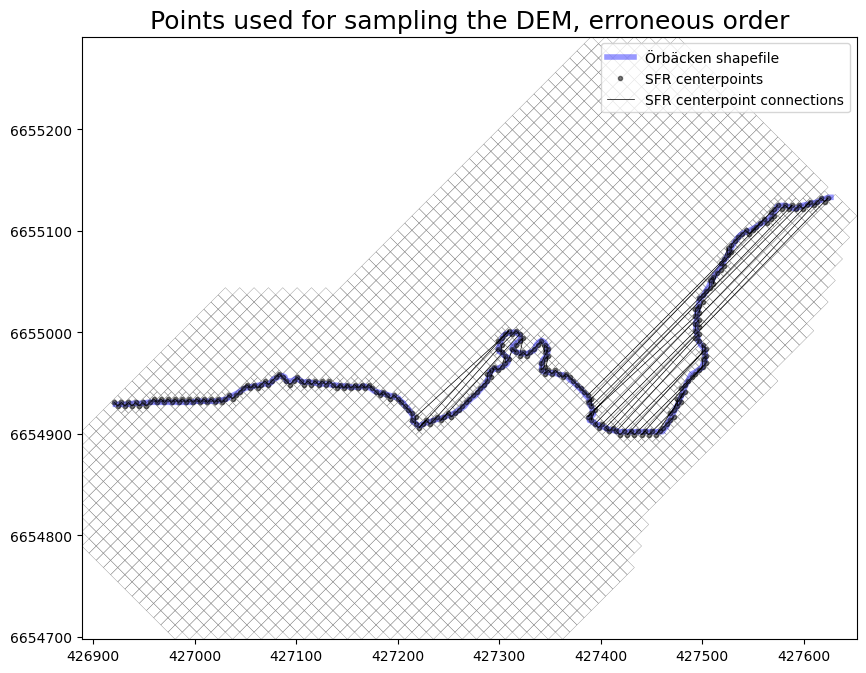

In [68]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Points used for sampling the DEM, erroneous order', fontsize=18)

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

ax.plot(orbacken_shp[:,0],orbacken_shp[:,1], c='blue', lw=4, label='Örbäcken shapefile', alpha=0.4)
ax.plot(sfr_centerpoints[:,0], sfr_centerpoints[:,1], 'k.', alpha=0.5, label='SFR centerpoints')
ax.plot(sfr_centerpoints[:,0], sfr_centerpoints[:,1], lw=0.5, color='black', label='SFR centerpoint connections')
    
plt.legend()
plt.show()

Just to illustrate this problem further we compare the actual length of the creek with the length produced by the unordered list of intersected SFR-cells:

In [69]:
print(f'Creek Örbäcken Shapefile length: {LineString(orbacken_shp).length:.2f} meters')
print(f'Length between (unordered) SFR-cell centerpoints: {LineString(sfr_centerpoints).length:.2f} meters')

Creek Örbäcken Shapefile length: 1069.29 meters
Length between (unordered) SFR-cell centerpoints: 4653.57 meters


However, it appears that the total length of intersected line segments sums up to the expected length of the creek. This is great, because it is a verification that the intersected cell data is usable **as long as the order is corrected**:

In [70]:
print(f'Length of intersected line segments: {sum(df.lengths.values):.2f} meters')

Length of intersected line segments: 1069.29 meters


So before we fix the order, lets discuss why this happened. Well, the current best guess is that a combination of grid orientation in relation to the creek **and** the size of the creek (hence size of bounding box) in relation to the model grid caused the spatial indexing method used by Shapely (Flopy uses Shapely (which in turn use GEOS) in the background for grid intersections) to be confused.

A Voronoi grid would likely not be affected by this issue.

OK. Lets fix the order of the points. The following solution is a modification of a method presented in this Stackoverflow issue: https://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line

Lets define the function:

In [71]:
def order_points(points, ind):
    points = [ tuple(point) for point in points ] # transform array of arrays into array of points
    points_new = [ points.pop(ind) ]  # initialize a new list of points with the known first point
    pcurr      = points_new[-1]       # initialize the current point (as the known point)
    while len(points)>0:
        d      = np.linalg.norm(np.array(points) - np.array(pcurr), axis=1)  # distances between pcurr and all other remaining points
        ind    = d.argmin()                   # index of the closest point
        points_new.append( points.pop(ind) )  # append the closest point to points_new
        pcurr  = points_new[-1]               # update the current point
    points_new = np.asarray([np.asarray(point) for point in points_new]) # re-transform array of points into array of arrays
    return points_new

Create an ordered version of the list and visualize:

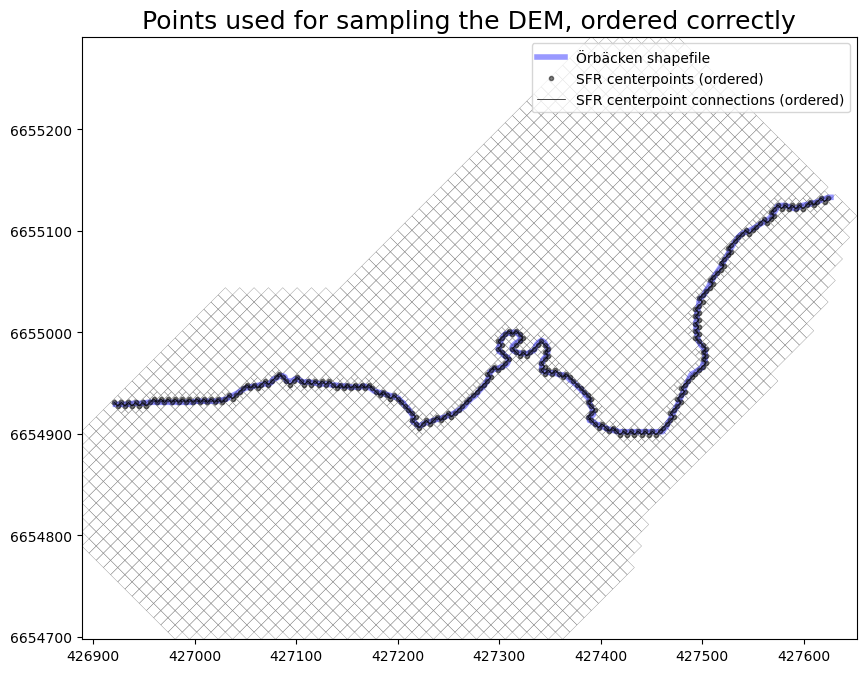

In [72]:
sfr_centerpoints_ordered = order_points(sfr_centerpoints, 0)

fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Points used for sampling the DEM, ordered correctly', fontsize=18)

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

ax.plot(orbacken_shp[:,0],orbacken_shp[:,1], c='blue', lw=4, label='Örbäcken shapefile', alpha=0.4)
ax.plot(sfr_centerpoints_ordered[:,0], sfr_centerpoints_ordered[:,1], 'k.', alpha=0.5, label='SFR centerpoints (ordered)')
ax.plot(sfr_centerpoints_ordered[:,0], sfr_centerpoints_ordered[:,1], lw=0.5, color='black', label='SFR centerpoint connections (ordered)')
    
plt.legend()
plt.show()

The next step is to sort the dataframe containing the intersected cells according to the sorted list. Let's see the DF again:

In [73]:
display(df)

,cellids,vertices,lengths,ixshapes
0,4,"((426922.3957468286, 6654929.0), (426922.0, 66...",0.395747,"LINESTRING (426922.3957468286 6654929, 426922 ..."
1,6,"((426926.0609766315, 6654929.0), (426926.0, 66...",3.665230,"LINESTRING (426926.0609766315 6654929, 426926 ..."
2,7,"((426929.4668147354, 6654929.0), (426926.06097...",3.405838,"LINESTRING (426929.4668147354 6654929, 426926...."
3,29,"((426933.1320443483, 6654929.0), (426930.0, 66...",3.665230,"LINESTRING (426933.1320443483 6654929, 426930 ..."
4,32,"((426937.1723533241, 6654929.634470665), (4269...",4.103134,LINESTRING (426937.1723533241 6654929.63447066...
...,...,...,...,...
261,2886,"((427461.47114062397, 6654902.706710936), (427...",6.742577,LINESTRING (427461.471140624 6654902.706710936...
262,2887,"((427464.624459691, 6654906.624459691), (42746...",5.053523,LINESTRING (427464.624459691 6654906.624459691...
263,2890,"((427466.9279948907, 6654911.391992336), (4274...",5.366338,LINESTRING (427466.9279948907 6654911.39199233...
264,2891,"((427469.4636850218, 6654915.9273700435), (427...",5.205484,LINESTRING (427469.4636850218 6654915.92737004...


Append the coordinates of the erroneously ordered centerpoints as a new column:

In [74]:
df['ctp_coord'] = [value for index, value in enumerate(sfr_centerpoints)]
df['ctp_ind'] = [index for index, value in enumerate(sfr_centerpoints)]
display(df.head())

,cellids,vertices,lengths,ixshapes,ctp_coord,ctp_ind
0,4,"((426922.3957468286, 6654929.0), (426922.0, 66...",0.395747,"LINESTRING (426922.3957468286 6654929, 426922 ...","[426920.6928278733, 6654930.832614949]",0
1,6,"((426926.0609766315, 6654929.0), (426926.0, 66...",3.665230,"LINESTRING (426926.0609766315 6654929, 426926 ...","[426924.2283617318, 6654927.2970809955]",1
2,7,"((426929.4668147354, 6654929.0), (426926.06097...",3.405838,"LINESTRING (426929.4668147354 6654929, 426926....","[426927.7638956851, 6654930.832614854]",2
3,29,"((426933.1320443483, 6654929.0), (426930.0, 66...",3.665230,"LINESTRING (426933.1320443483 6654929, 426930 ...","[426931.29942954367, 6654927.2970809005]",3
4,32,"((426937.1723533241, 6654929.634470665), (4269...",4.103134,LINESTRING (426937.1723533241 6654929.63447066...,"[426934.83496349695, 6654930.832614759]",4


Create a second dataframe using the coordinates of the correctly ordered centerpoints:

In [75]:
df_ordered = pd.DataFrame({'ctp_coord': [value for index, value in enumerate(sfr_centerpoints_ordered)]})
display(df_ordered.head())

,ctp_coord
0,"[426920.6928278733, 6654930.832614949]"
1,"[426924.2283617318, 6654927.2970809955]"
2,"[426927.7638956851, 6654930.832614854]"
3,"[426931.29942954367, 6654927.2970809005]"
4,"[426934.83496349695, 6654930.832614759]"


Now we will re-index the original dataframe using the centerpoint coordinates. However, before we can do so, they must first be converted into string datatype:

In [76]:
def coord_as_str(arr):
    return [str(coordinate) for coordinate in arr]

Create string version columns of centerpoint coordinates of both dataframes:

In [77]:
df['ctp_coord_str'] = coord_as_str(df.ctp_coord.values)
df_ordered['ctp_coord_str'] = coord_as_str(df_ordered.ctp_coord.values)

Set the coordinates as dataframe index for the original DF and reindex according the the ordered dataframe:

In [78]:
df = df.set_index('ctp_coord_str')
df = df.reindex(index=df_ordered['ctp_coord_str'])

Reset the index and display the results. By comparing the df.index with df.ctp_ind we can see that the original dataframe has been reordered according to the ordered list of SFR-cells:

In [79]:
df = df.reset_index()
display(df)

,ctp_coord_str,cellids,vertices,lengths,ixshapes,ctp_coord,ctp_ind
0,[ 426920.69282787 6654930.83261495],4,"((426922.3957468286, 6654929.0), (426922.0, 66...",0.395747,"LINESTRING (426922.3957468286 6654929, 426922 ...","[426920.6928278733, 6654930.832614949]",0
1,[ 426924.22836173 6654927.297081 ],6,"((426926.0609766315, 6654929.0), (426926.0, 66...",3.665230,"LINESTRING (426926.0609766315 6654929, 426926 ...","[426924.2283617318, 6654927.2970809955]",1
2,[ 426927.76389569 6654930.83261485],7,"((426929.4668147354, 6654929.0), (426926.06097...",3.405838,"LINESTRING (426929.4668147354 6654929, 426926....","[426927.7638956851, 6654930.832614854]",2
3,[ 426931.29942954 6654927.2970809 ],29,"((426933.1320443483, 6654929.0), (426930.0, 66...",3.665230,"LINESTRING (426933.1320443483 6654929, 426930 ...","[426931.29942954367, 6654927.2970809005]",3
4,[ 426934.8349635 6654930.83261476],32,"((426937.1723533241, 6654929.634470665), (4269...",4.103134,LINESTRING (426937.1723533241 6654929.63447066...,"[426934.83496349695, 6654930.832614759]",4
...,...,...,...,...,...,...,...
261,[ 427610.12194214 6655125.28697054],2556,"((427611.15555727994, 6655127.78888932), (4276...",2.841136,LINESTRING (427611.1555572799 6655127.78888932...,"[427610.1219421353, 6655125.286970539]",218
262,[ 427613.65747609 6655128.8225044 ],2559,"((427616.3436762449, 6655129.671838122), (4276...",5.534985,LINESTRING (427616.3436762449 6655129.67183812...,"[427613.6574760886, 6655128.8225043975]",219
263,[ 427617.19301004 6655132.35803826],2560,"((427619.55575856194, 6655131.185252854), (427...",3.555681,LINESTRING (427619.5557585619 6655131.18525285...,"[427617.19301004196, 6655132.358038256]",220
264,[ 427620.7285439 6655128.8225043],2562,"((427621.3149366054, 6655131.771645535), (4276...",1.854336,LINESTRING (427621.3149366054 6655131.77164553...,"[427620.72854390054, 6655128.8225043025]",221


### 3.3.2 Sample the DEM raster for streambed elevations
Now that the dataframe is in order, we can sample the DEM raster for the streambed elevation input parameter.

To do so lets extract the X and Y coordinates from the coordinates column:

In [80]:
x = np.asarray([np.asarray(i) for i in df['ctp_coord'].values])[:,0]
y = np.asarray([np.asarray(i) for i in df['ctp_coord'].values])[:,1]

Create a new column to hold the streambed elevations using the sampled data:

In [81]:
df['rtp'] = [lyr1_top.sample_point(x[i], y[i], band=1) for i in range(len(x))]

The order of the dataframe now has to be inverted, as the streambed elevation should go from high to low:

In [82]:
df = df.reindex(index=df.index[::-1]).reset_index(drop=True)
display(df) # See rtp column to the right. Values are in meters above sea level.

,ctp_coord_str,cellids,vertices,lengths,ixshapes,ctp_coord,ctp_ind,rtp
0,[ 427624.26407785 6655132.35803816],2564,"((427627.0, 6655133.0), (427625.0, 6655133.0),...",5.884398,"LINESTRING (427627 6655133, 427625 6655133, 42...","[427624.26407785376, 6655132.358038161]",222,143.612000
1,[ 427620.7285439 6655128.8225043],2562,"((427621.3149366054, 6655131.771645535), (4276...",1.854336,LINESTRING (427621.3149366054 6655131.77164553...,"[427620.72854390054, 6655128.8225043025]",221,143.497696
2,[ 427617.19301004 6655132.35803826],2560,"((427619.55575856194, 6655131.185252854), (427...",3.555681,LINESTRING (427619.5557585619 6655131.18525285...,"[427617.19301004196, 6655132.358038256]",220,143.452301
3,[ 427613.65747609 6655128.8225044 ],2559,"((427616.3436762449, 6655129.671838122), (4276...",5.534985,LINESTRING (427616.3436762449 6655129.67183812...,"[427613.6574760886, 6655128.8225043975]",219,143.494202
4,[ 427610.12194214 6655125.28697054],2556,"((427611.15555727994, 6655127.78888932), (4276...",2.841136,LINESTRING (427611.1555572799 6655127.78888932...,"[427610.1219421353, 6655125.286970539]",218,143.559296
...,...,...,...,...,...,...,...,...
261,[ 426934.8349635 6654930.83261476],32,"((426937.1723533241, 6654929.634470665), (4269...",4.103134,LINESTRING (426937.1723533241 6654929.63447066...,"[426934.83496349695, 6654930.832614759]",4,133.245804
262,[ 426931.29942954 6654927.2970809 ],29,"((426933.1320443483, 6654929.0), (426930.0, 66...",3.665230,"LINESTRING (426933.1320443483 6654929, 426930 ...","[426931.29942954367, 6654927.2970809005]",3,133.664200
263,[ 426927.76389569 6654930.83261485],7,"((426929.4668147354, 6654929.0), (426926.06097...",3.405838,"LINESTRING (426929.4668147354 6654929, 426926....","[426927.7638956851, 6654930.832614854]",2,134.306702
264,[ 426924.22836173 6654927.297081 ],6,"((426926.0609766315, 6654929.0), (426926.0, 66...",3.665230,"LINESTRING (426926.0609766315 6654929, 426926 ...","[426924.2283617318, 6654927.2970809955]",1,135.083694


Because SFR require decreasing streambed elevation in the downstream direction, we plot the sampled elevations in the `rtp` column:

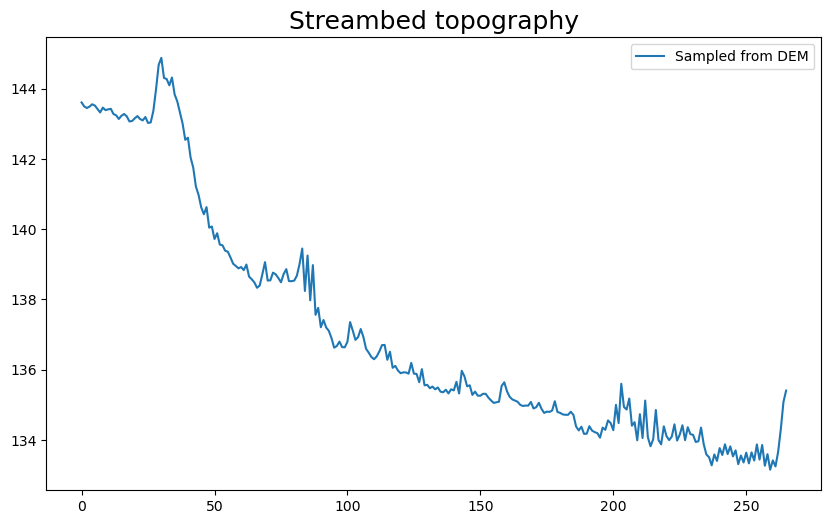

In [83]:
fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Streambed topography', fontsize=18)

plt.plot(df.rtp.values, label='Sampled from DEM')

plt.legend()
plt.show()

As we can see, roughness in the DEM cause upward spikes at different points along the generally decreasing elevation. To fix this we apply a smoothing algorithm (inspired by the SFRMaker package, which at the time of writing unfortunately does not work with DISV grids):

In [84]:
# This can probably be handled with more grace, but it gets the job done
smoothed_sfr_elevation = []
current_min = 0
for count, element in enumerate(df.rtp.values):
    if count == 0:
        smoothed_sfr_elevation.append(element)
        current_min = element
    else:
        if element > current_min:
            new_min = current_min - 0.0001
            smoothed_sfr_elevation.append(new_min)
            current_min = new_min
        else:
            smoothed_sfr_elevation.append(element)
            current_min = element

Lets compare the smoothened version with the original sampled data:

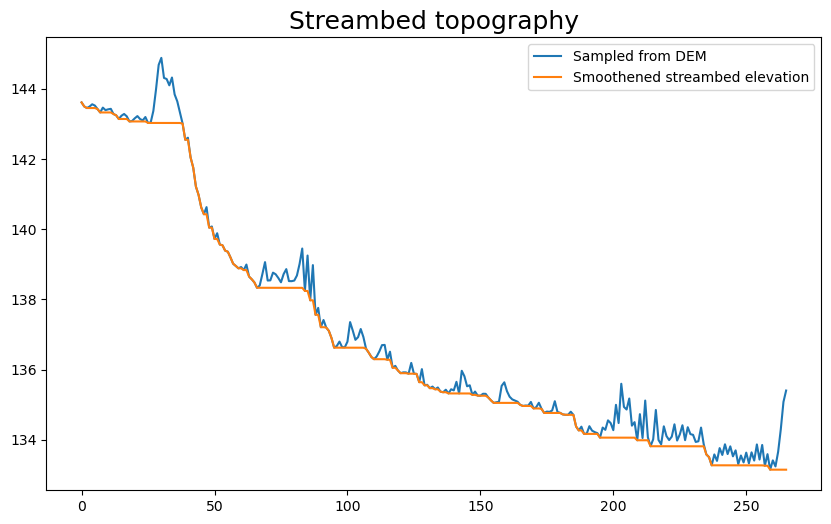

In [85]:
fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.add_subplot(1, 1, 1)
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Streambed topography', fontsize=18)

plt.plot(df.rtp.values, label='Sampled from DEM')
plt.plot(smoothed_sfr_elevation, label='Smoothened streambed elevation')

plt.legend()
plt.show()

We now have a working model input that SFR will accept. Let's update the `rtp` column with the new values:

In [86]:
df['rtp'] = smoothed_sfr_elevation

### 3.3.3. Create the `PACKAGEDATA` input

We will now create a dictionary that hold the `PACKAGEDATA` input required by SFR. Starting by preprocessing `ncon`:

In [87]:
ncon = [2 for i in range(len(df))] # All reaches (except for the first and last) will have 2 connections; upstream and downstream.
ncon[0] = 1 # First reach will only have one connection
ncon[-1] = 1 # Last reach will only have one connection

Then we move on to the rest of parameters and display the dictionary as a dataframe:

In [88]:
sfr_packagedata = {
    'rno': df.index, # Reach numbers are in sequential order along creek flow path. Cannot be int64.
    'cellid': [(0, i) for i in df.cellids.values], # CellID is a tuple which contain layer number (zero indexed) and cell2d id.
    'rlen': [round(i, 2) for i in df.lengths.values], # Acquired from intersecting model grid with shapefile.
    'rwid': [2. for i in range(len(df))], # Creek Örbäcken is approximately 2 meters wide.
    'rgrd': [0.001 for i in range(len(df))], # Sensible default value.
    'rtp': [round(i, 2) for i in df.rtp.values], # Sampled from DEM and then processed through smoothing algorithm.
    'rbth': [1.0 for i in range(len(df))], # Bottom depth is unknown. This is a "best guess"-value.
    'rhk': [86.4 for i in range(len(df))], # Initial Hydraulic Conductivity guess. PEST will adjust this parameter.
    'man': [3e-02 for i in range(len(df))], # Manning's roughness coefficient. Sensible default value.
    'ncon': ncon, # All reaches (except for the first and last) will have 2 connections; upstream and downstream.
    'ustrf': [1 for i in range(len(df))], # Since there are no diversions this value will be 1 for all reaches
    'ndv': [0 for i in range(len(df))], # Since there are no diversions this value will be 0 for all reaches
}
sfr_packagedata_df = pd.DataFrame(sfr_packagedata)
display(sfr_packagedata_df)

,rno,cellid,rlen,rwid,rgrd,rtp,rbth,rhk,man,ncon,ustrf,ndv
0,0,"(0, 2564)",5.88,2.0,0.001,143.61,1.0,86.4,0.03,1,1,0
1,1,"(0, 2562)",1.85,2.0,0.001,143.50,1.0,86.4,0.03,2,1,0
2,2,"(0, 2560)",3.56,2.0,0.001,143.45,1.0,86.4,0.03,2,1,0
3,3,"(0, 2559)",5.53,2.0,0.001,143.45,1.0,86.4,0.03,2,1,0
4,4,"(0, 2556)",2.84,2.0,0.001,143.45,1.0,86.4,0.03,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
261,261,"(0, 32)",4.10,2.0,0.001,133.15,1.0,86.4,0.03,2,1,0
262,262,"(0, 29)",3.67,2.0,0.001,133.15,1.0,86.4,0.03,2,1,0
263,263,"(0, 7)",3.41,2.0,0.001,133.15,1.0,86.4,0.03,2,1,0
264,264,"(0, 6)",3.67,2.0,0.001,133.15,1.0,86.4,0.03,2,1,0


### 3.3.4 Create the `CONNECTIONDATA` input:

This is a fairly simple matter since there are no diversions along this section in creek Örbäcken (we treat the stream as a single unit).

In [89]:
# connectiondata IC (downstream negative, upstream positive)
sfr_conn_arr = np.dstack((sfr_packagedata['rno'], sfr_packagedata['rno'] - 1, (sfr_packagedata['rno'] + 1) * -1))[0]

In [90]:
# turn sfr_conn_arr into a list
sfr_conndata = [list(i) for i in sfr_conn_arr]

In [91]:
# remove upstream connection from first reach & downstream connection from last reach and display the data
sfr_conndata[0], sfr_conndata[-1] = sfr_conndata[0][:-1], sfr_conndata[-1][:-1]
sfr_conndata

[[0, -1],
 [1, 0, -2],
 [2, 1, -3],
 [3, 2, -4],
 [4, 3, -5],
 [5, 4, -6],
 [6, 5, -7],
 [7, 6, -8],
 [8, 7, -9],
 [9, 8, -10],
 [10, 9, -11],
 [11, 10, -12],
 [12, 11, -13],
 [13, 12, -14],
 [14, 13, -15],
 [15, 14, -16],
 [16, 15, -17],
 [17, 16, -18],
 [18, 17, -19],
 [19, 18, -20],
 [20, 19, -21],
 [21, 20, -22],
 [22, 21, -23],
 [23, 22, -24],
 [24, 23, -25],
 [25, 24, -26],
 [26, 25, -27],
 [27, 26, -28],
 [28, 27, -29],
 [29, 28, -30],
 [30, 29, -31],
 [31, 30, -32],
 [32, 31, -33],
 [33, 32, -34],
 [34, 33, -35],
 [35, 34, -36],
 [36, 35, -37],
 [37, 36, -38],
 [38, 37, -39],
 [39, 38, -40],
 [40, 39, -41],
 [41, 40, -42],
 [42, 41, -43],
 [43, 42, -44],
 [44, 43, -45],
 [45, 44, -46],
 [46, 45, -47],
 [47, 46, -48],
 [48, 47, -49],
 [49, 48, -50],
 [50, 49, -51],
 [51, 50, -52],
 [52, 51, -53],
 [53, 52, -54],
 [54, 53, -55],
 [55, 54, -56],
 [56, 55, -57],
 [57, 56, -58],
 [58, 57, -59],
 [59, 58, -60],
 [60, 59, -61],
 [61, 60, -62],
 [62, 61, -63],
 [63, 62, -64],
 [64, 63,

### 3.3.5 Create the `PERIODDATA` input:
Still work in progress...

In [92]:
reaches = [i for i in range(len(sfr_packagedata['rno']))]
status = ['STATUS' for i in range(len(sfr_packagedata['rno']))]
active = ['ACTIVE' for i in range(len(sfr_packagedata['rno']))]
us_fr = ['UPSTREAM_FRACTION' for i in range(len(sfr_packagedata['rno']))]
us_fr_val = [1. for i in range(len(sfr_packagedata['rno']))]

In [93]:
sfr_spd = [list(i) for i in list(zip(reaches, status, active))]

In [94]:
len(sfr_spd)

266

In [95]:
sfr_spd = []
for i in sfr_packagedata['rno']:
    sfr_spd.append([i, 'STATUS', 'ACTIVE'])
    sfr_spd.append([i, 'UPSTREAM_FRACTION', 1.0])
#    sfr_spd.append([i, 'inflow', 0.0])
#    sfr_spd.append([i, 'rainfall', 0.0])
#    sfr_spd.append([i, 'evaporation', 0.0])
#    sfr_spd.append([i, 'runoff', 0.0])
    sfr_spd.append([i, 'MANNING', 0.03])

In [96]:
sfr_spd

[[0, 'STATUS', 'ACTIVE'],
 [0, 'UPSTREAM_FRACTION', 1.0],
 [0, 'MANNING', 0.03],
 [1, 'STATUS', 'ACTIVE'],
 [1, 'UPSTREAM_FRACTION', 1.0],
 [1, 'MANNING', 0.03],
 [2, 'STATUS', 'ACTIVE'],
 [2, 'UPSTREAM_FRACTION', 1.0],
 [2, 'MANNING', 0.03],
 [3, 'STATUS', 'ACTIVE'],
 [3, 'UPSTREAM_FRACTION', 1.0],
 [3, 'MANNING', 0.03],
 [4, 'STATUS', 'ACTIVE'],
 [4, 'UPSTREAM_FRACTION', 1.0],
 [4, 'MANNING', 0.03],
 [5, 'STATUS', 'ACTIVE'],
 [5, 'UPSTREAM_FRACTION', 1.0],
 [5, 'MANNING', 0.03],
 [6, 'STATUS', 'ACTIVE'],
 [6, 'UPSTREAM_FRACTION', 1.0],
 [6, 'MANNING', 0.03],
 [7, 'STATUS', 'ACTIVE'],
 [7, 'UPSTREAM_FRACTION', 1.0],
 [7, 'MANNING', 0.03],
 [8, 'STATUS', 'ACTIVE'],
 [8, 'UPSTREAM_FRACTION', 1.0],
 [8, 'MANNING', 0.03],
 [9, 'STATUS', 'ACTIVE'],
 [9, 'UPSTREAM_FRACTION', 1.0],
 [9, 'MANNING', 0.03],
 [10, 'STATUS', 'ACTIVE'],
 [10, 'UPSTREAM_FRACTION', 1.0],
 [10, 'MANNING', 0.03],
 [11, 'STATUS', 'ACTIVE'],
 [11, 'UPSTREAM_FRACTION', 1.0],
 [11, 'MANNING', 0.03],
 [12, 'STATUS', 'ACTIV

### 3.3.6 Create the SFR model input
Still work in progress...

In [97]:
sfr = flopy.mf6.ModflowGwfsfr(
    gwf,
    nreaches=len(df),
    packagedata=[list(data) for data in sfr_packagedata_df.to_numpy()],
    connectiondata=sfr_conndata,
    maximum_iterations=100,
    unit_conversion=86400.,
    #boundnames=False,
    pname='sfr',
    perioddata=sfr_spd,
    print_flows=True,
    print_stage=True,
    save_flows=True,
#    boundnames=True, to be implemented after some history matching is done
    budget_filerecord=ml_name + ".sfr.bud",
)

# Setup observations

In [98]:
observations_pth = os.path.join('..', 'data', 'observations') # Measured data (field obs)

### Head obs

In [99]:
headobs = pd.read_excel(os.path.join(observations_pth, 'obs_head_per_layer.xlsx'))
headobs['shapely_point'] = [Point(row['POINT_X'], row['POINT_Y']) for index, row in headobs.iterrows()]

In [100]:
headobs['cell2d'] = [ix.intersect(i).cellids[0] for i in headobs['shapely_point']]

In [101]:
display(headobs)

,NAME,POINT_X,POINT_Y,LAYER,shapely_point,cell2d
0,B9-2,426918.374000,6.654803e+06,1,POINT (426918.374 6654803.298),350
1,B10-2,427074.709423,6.654805e+06,1,POINT (427074.709423 6654805.17421),1253
2,B12-1,427448.188505,6.655156e+06,1,POINT (427448.188505 6655156.014),1386
3,B16-1,427409.547301,6.655023e+06,1,POINT (427409.547301 6655023.27117),1980
4,B2-1,427384.172044,6.655037e+06,1,POINT (427384.172044 6655037.1887),1751
...,...,...,...,...,...,...
139,NI1705-2,427215.444386,6.654958e+06,3,POINT (427215.444386 6654957.96958),1197
140,NI1706-2,427250.038227,6.654940e+06,3,POINT (427250.038227 6654940.18623),1438
141,NI1707-1,427229.096032,6.654943e+06,3,POINT (427229.096032 6654942.66111),1355
142,NI1708-1,427447.873358,6.654978e+06,3,POINT (427447.873358 6654977.69539),2447


In [102]:
headobs_input = [(row['NAME'], 'HEAD', (row['LAYER'] - 1, row['cell2d']), (row['LAYER'] - 1, row['cell2d'] + 1)) for index, row in headobs.iterrows()]
headobs_input

[('B9-2', 'HEAD', (0, 350), (0, 351)),
 ('B10-2', 'HEAD', (0, 1253), (0, 1254)),
 ('B12-1', 'HEAD', (0, 1386), (0, 1387)),
 ('B16-1', 'HEAD', (0, 1980), (0, 1981)),
 ('B2-1', 'HEAD', (0, 1751), (0, 1752)),
 ('B22-1', 'HEAD', (0, 1472), (0, 1473)),
 ('B27', 'HEAD', (0, 1387), (0, 1388)),
 ('B29', 'HEAD', (0, 1556), (0, 1557)),
 ('KB1-1', 'HEAD', (0, 2346), (0, 2347)),
 ('KB4-3', 'HEAD', (0, 1278), (0, 1279)),
 ('NI1301-1', 'HEAD', (0, 1474), (0, 1475)),
 ('NI1302-1', 'HEAD', (0, 1473), (0, 1474)),
 ('NI1403-1', 'HEAD', (0, 2355), (0, 2356)),
 ('NI1405-1', 'HEAD', (0, 2195), (0, 2196)),
 ('NI1407-1', 'HEAD', (0, 1470), (0, 1471)),
 ('NI1408-1', 'HEAD', (0, 1383), (0, 1384)),
 ('NI1409-1', 'HEAD', (0, 1677), (0, 1678)),
 ('NI1410-1', 'HEAD', (0, 1679), (0, 1680)),
 ('NI1411-1', 'HEAD', (0, 1568), (0, 1569)),
 ('NI1412-1', 'HEAD', (0, 2354), (0, 2355)),
 ('NI1413-1', 'HEAD', (0, 2449), (0, 2450)),
 ('NI1501-1', 'HEAD', (0, 1296), (0, 1297)),
 ('NI1502-2', 'HEAD', (0, 1146), (0, 1147)),
 ('

In [103]:
# observations
obs_recarray = {'{}.obs.csv'.format('head'): headobs_input}
obs = flopy.mf6.ModflowUtlobs(
    gwf,
    pname = 'gwf_obs',
    filename = '{}.obs'.format(ml_name),
    digits = 10,
    print_input = True,
    continuous = obs_recarray
)

### SFR obs

In [104]:
sfrobs = pd.read_excel(os.path.join(observations_pth, 'obs_flow_and_stage.xlsx'))

In [105]:
sfrobs['shapely_point'] = [Point(row['POINT_X'], row['POINT_Y']) for index, row in sfrobs.iterrows()]

In [106]:
sfrobs['cell2d'] = [ix.intersect(i).cellids[0] for i in sfrobs['shapely_point']]

In [107]:
display(sfrobs)

,NAME,POINT_X,POINT_Y,TYPE,shapely_point,cell2d
0,NI15-O1-STG,427391.988166,6.654917e+06,STAGE,POINT (427391.988166 6654917.31795),2436
1,NI15-O44-STG,427385.272148,6.654938e+06,STAGE,POINT (427385.272148 6654938.18864),2250
2,NI15-O46-STG,427316.293421,6.655000e+06,STAGE,POINT (427316.293421 6655000.15848),1545
3,NI15-O47-STG,427294.946661,6.654962e+06,STAGE,POINT (427294.946661 6654962.31574),1638
4,NI15-O48-STG,427166.670722,6.654947e+06,STAGE,POINT (427166.670722 6654946.6169),946
5,GAGE-1,427030.760000,6.654934e+06,INFLOW,POINT (427030.76 6654934.26),248


In [108]:
sfr_packagedata_df['cell2d'] = [i[1] for i in sfr_packagedata_df.cellid.values]

In [109]:
merged_sfr_obs = pd.merge(sfrobs, sfr_packagedata_df, on=['cell2d'], how='inner')

In [110]:
merged_sfr_obs

,NAME,POINT_X,POINT_Y,TYPE,shapely_point,cell2d,rno,cellid,rlen,rwid,rgrd,rtp,rbth,rhk,man,ncon,ustrf,ndv
0,NI15-O44-STG,427385.272148,6.654938e+06,STAGE,POINT (427385.272148 6654938.18864),2250,107,"(0, 2250)",5.88,2.0,0.001,136.60,1.0,86.4,0.03,2,1,0
1,NI15-O46-STG,427316.293421,6.655000e+06,STAGE,POINT (427316.293421 6655000.15848),1545,141,"(0, 1545)",3.31,2.0,0.001,135.32,1.0,86.4,0.03,2,1,0
2,NI15-O47-STG,427294.946661,6.654962e+06,STAGE,POINT (427294.946661 6654962.31574),1638,156,"(0, 1638)",5.40,2.0,0.001,135.06,1.0,86.4,0.03,2,1,0
3,NI15-O48-STG,427166.670722,6.654947e+06,STAGE,POINT (427166.670722 6654946.6169),946,195,"(0, 946)",4.71,2.0,0.001,134.07,1.0,86.4,0.03,2,1,0
4,GAGE-1,427030.760000,6.654934e+06,INFLOW,POINT (427030.76 6654934.26),248,234,"(0, 248)",5.67,2.0,0.001,133.82,1.0,86.4,0.03,2,1,0


In [111]:
sfrobs_input = [(row['NAME'], row['TYPE'], row['rno']) for index, row in merged_sfr_obs.iterrows()]
sfrobs_input

[('NI15-O44-STG', 'STAGE', 107),
 ('NI15-O46-STG', 'STAGE', 141),
 ('NI15-O47-STG', 'STAGE', 156),
 ('NI15-O48-STG', 'STAGE', 195),
 ('GAGE-1', 'INFLOW', 234)]

In [112]:
sfr_obs_recarray = {'{}.obs.csv'.format('sfr'): sfrobs_input}
sfr.obs.initialize(
    filename = '{}.sfr.obs'.format(ml_name),
    digits = 10,
    print_input = True,
    continuous = sfr_obs_recarray
)

##  Run model

In [113]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model experimental...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package sto...
    writing package ghb...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 180 based on size of stress_period_data
    writing package rch...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 2955 based on size of stress_period_data
    writing package sfr...
    writing package gwf_obs...
    writing package obs_0...


In [114]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\bins\win\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 21:14:51 with IFORT compiler (ver. 19.10.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources So

(True, [])

In [128]:
#Check the budget
mf_list = flopy.utils.Mf6ListBudget(os.path.join(ml_ws, f"{gwf.name}.lst"), timeunit='days') #MF6ListBudget is different from MfListBudget...*sigh*
incremental, cumulative = mf_list.get_budget()
incrementaldf, cumulativedf = mf_list.get_dataframes(start_datetime="01-09-2017")

incrementaldf

,STO-SS_IN,STO-SY_IN,GHB_IN,RCH_IN,SFR_IN,TOTAL_IN,STO-SS_OUT,STO-SY_OUT,GHB_OUT,RCH_OUT,SFR_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
2017-01-10,0.000000e+00,0.000000e+00,9090.697266,140.136902,480.505493,9711.339844,0.0,0.0,2421.786133,0.0,7289.603027,9711.388672,4.903600e-02,-0.0
2021-01-09,1.274800e-12,1.721000e-09,9090.705078,140.136902,480.509796,9711.351562,0.0,0.0,2421.757080,0.0,7289.594727,9711.351562,8.607000e-07,-0.0


Model solved with a run time of less than 10 seconds (considerably faster than the model built using ModelMuse). Lets visualize the results using a cross section:

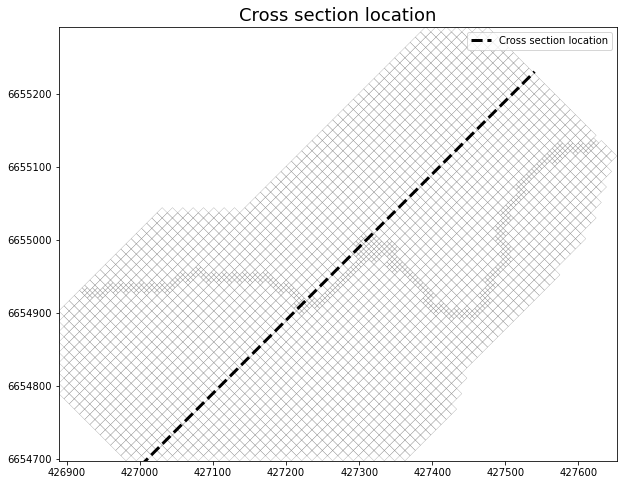

In [116]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Cross section location', fontsize=18)

# use PlotMapView to plot a DISV (vertex) model
mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

xsection = np.array([(427000, 6654690), (427540, 6655230)])
plt.plot(xsection.T[0], xsection.T[1], color='k', linestyle='--', lw=3, label='Cross section location')
    
plt.legend()
plt.show()

Read model solution:

In [117]:
headfile = '{}.hds'.format(ml_name)
fname = os.path.join(ml_ws, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)
h = hds.get_data()

Plot cross section:

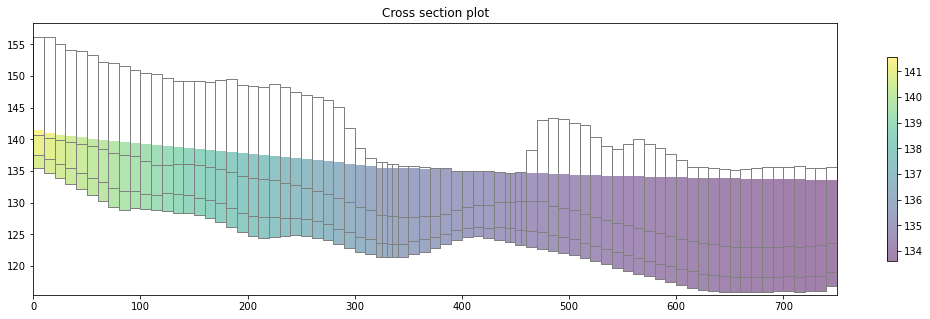

In [118]:
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Cross section plot")

xsect = flopy.plot.PlotCrossSection(model=gwf, line={"line": xsection})
patch_collection = xsect.plot_array(h, head=h, alpha=0.5)
line_collection = xsect.plot_grid()
cb = plt.colorbar(patch_collection, shrink=0.75)

Some of the cells in layer 1 are dry. Considering the model is parametrically homogenous this is probably not a big issue at this point. Lets visualize the results for all layers using PlotMapView:

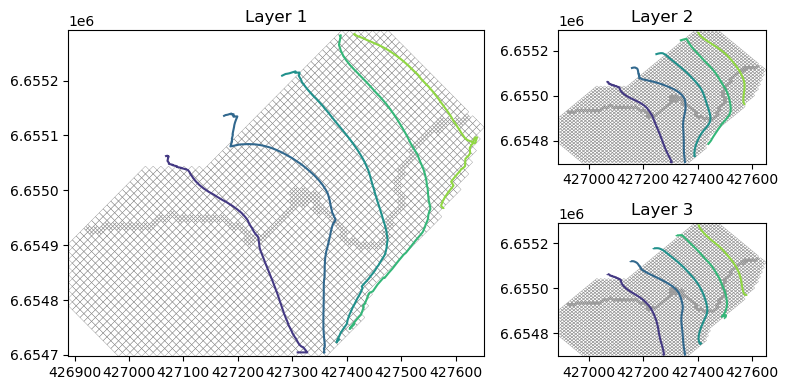

In [119]:
fig = plt.figure(figsize=(8,4), dpi=100)

axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[2, 1]})

axs['Left'].set_title('Layer 1')
axs['TopRight'].set_title('Layer 2')
axs['BottomRight'].set_title('Layer 3')

for index, ax in enumerate(axs):
    modelmap = flopy.plot.PlotMapView(model=gwf, ax=axs[ax])
    linecollection = modelmap.plot_grid(lw=0.25)
    contours = modelmap.contour_array(h[index])
    
plt.tight_layout()
plt.show()

End of notebook. Next notebook to run is scripted_lumpyrem_setup

In [120]:
#gwf.remove_package('tdis')

In [121]:
gwf.remove_package('rch')

In [122]:
rchcells = np.array(list(range(gridprops['ncpl'])), dtype=int)
rchcells[non_ghb_cells] = -1
rch_spd = [
    (0, rchcells[i], 1) for i in range(ncpl) if rchcells[i] > 0
]
rch_spd = {0: rch_spd, 1: rch_spd}

In [123]:
rch_spd

{0: [(0, 6, 1),
  (0, 7, 1),
  (0, 23, 1),
  (0, 24, 1),
  (0, 25, 1),
  (0, 26, 1),
  (0, 27, 1),
  (0, 28, 1),
  (0, 29, 1),
  (0, 30, 1),
  (0, 31, 1),
  (0, 32, 1),
  (0, 33, 1),
  (0, 34, 1),
  (0, 35, 1),
  (0, 36, 1),
  (0, 37, 1),
  (0, 38, 1),
  (0, 39, 1),
  (0, 40, 1),
  (0, 41, 1),
  (0, 42, 1),
  (0, 43, 1),
  (0, 44, 1),
  (0, 45, 1),
  (0, 46, 1),
  (0, 47, 1),
  (0, 48, 1),
  (0, 49, 1),
  (0, 52, 1),
  (0, 53, 1),
  (0, 54, 1),
  (0, 55, 1),
  (0, 56, 1),
  (0, 57, 1),
  (0, 58, 1),
  (0, 59, 1),
  (0, 60, 1),
  (0, 61, 1),
  (0, 62, 1),
  (0, 63, 1),
  (0, 64, 1),
  (0, 65, 1),
  (0, 66, 1),
  (0, 67, 1),
  (0, 68, 1),
  (0, 69, 1),
  (0, 70, 1),
  (0, 71, 1),
  (0, 72, 1),
  (0, 73, 1),
  (0, 74, 1),
  (0, 75, 1),
  (0, 76, 1),
  (0, 77, 1),
  (0, 78, 1),
  (0, 79, 1),
  (0, 80, 1),
  (0, 81, 1),
  (0, 82, 1),
  (0, 85, 1),
  (0, 86, 1),
  (0, 87, 1),
  (0, 88, 1),
  (0, 89, 1),
  (0, 90, 1),
  (0, 91, 1),
  (0, 92, 1),
  (0, 93, 1),
  (0, 94, 1),
  (0, 95, 1),
  (0,

In [124]:
rch = flopy.mf6.ModflowGwfrch(
    gwf,
    filename='{}.rch'.format(ml_name),
    stress_period_data=rch_spd,
    pname='rch',
    #auxiliary='MULTIPLIER',
    #auxmultname='MULTIPLIER',
    #boundnames=True,
    print_input=True,
    print_flows=True, 
    save_flows=True,
    fixed_cell=True,
)

In [125]:
#gwf.remove_package('sfr')

In [126]:
#gwf.remove_package('ghb')

In [127]:
#gwf.remove_package('npf')